In [4]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
#pip install -q -U keras-tuner
import keras_tuner as kt
from tensorflow.keras.layers import Dropout

In [5]:
# Load in Colorectal Histology dataset from tensorflow datasets

dataset_name = 'colorectal_histology'
dataset, dataset_info = tfds.load(
    name=dataset_name,
    split='train',
    with_info=True,
    as_supervised=True,
)

# Calculate the number of examples in each split
total_examples = dataset_info.splits['train'].num_examples
train_split = int(0.5 * total_examples)
val_split = int(0.3 * total_examples)
test_split = total_examples - train_split - val_split

# Split the dataset
training_set = dataset.take(train_split)
validation_set = dataset.skip(train_split).take(val_split)
testing_set = dataset.skip(train_split + val_split)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/5000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/colorectal_histology/2.0.0.incompleteUNLFZB/colorectal_histology-train.tfr…

Dataset colorectal_histology downloaded and prepared to /root/tensorflow_datasets/colorectal_histology/2.0.0. Subsequent calls will reuse this data.


,image,label
0,,4 (debris)
1,,5 (mucosa)
2,,5 (mucosa)
3,,0 (tumor)
4,,6 (adipose)

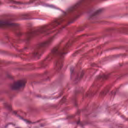
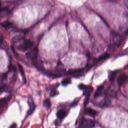
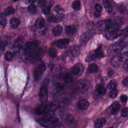
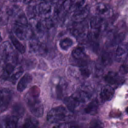
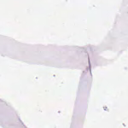

In [6]:
# View sample of the training set

tfds.as_dataframe(training_set.take(5), dataset_info)

In [7]:
# Create list of different categories
categories = ['tumor','stroma','complex','lympho','debris','mucosa','adipose','empty']

In [8]:
# Get count for unique label values for training data
train_counts = np.unique(np.fromiter(training_set.map(lambda x,y: y), float), return_counts=True)

for value, count in zip(*train_counts):
  print(int(value), count)

0 315
1 313
2 297
3 314
4 300
5 329
6 326
7 306


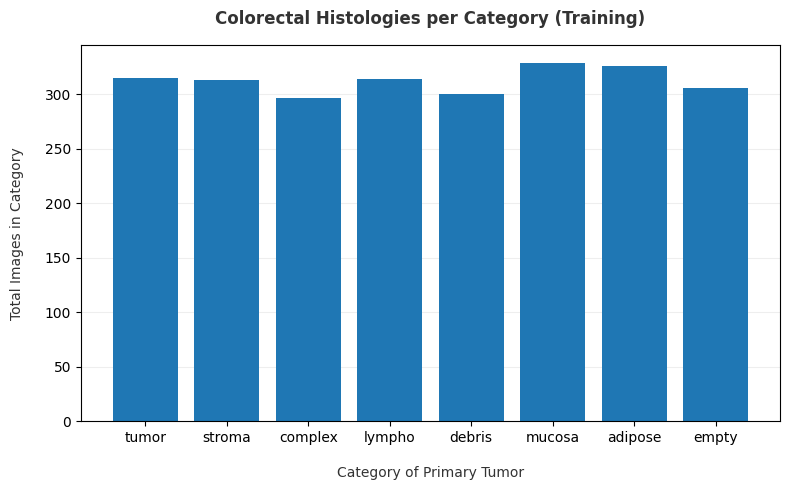

In [9]:
# Bar plot of training data category counts

plt.rcParams['figure.figsize'] = (8, 5)

fig,ax = plt.subplots()

ax.bar(train_counts[0],train_counts[1], tick_label=categories)
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#EEEEEE')
ax.xaxis.grid(False)

ax.set_xlabel('Category of Primary Tumor', labelpad=15, color='#333333')
ax.set_ylabel('Total Images in Category', labelpad=15, color='#333333')
ax.set_title('Colorectal Histologies per Category (Training)', pad=15, color='#333333',
             weight='bold')

fig.tight_layout()

In [10]:
# Get count for unique label values for validation data
valid_counts = np.unique(np.fromiter(validation_set.map(lambda x,y: y), float), return_counts=True)

for value, count in zip(*valid_counts):
  print(int(value), count)

0 169
1 198
2 196
3 182
4 191
5 190
6 181
7 193


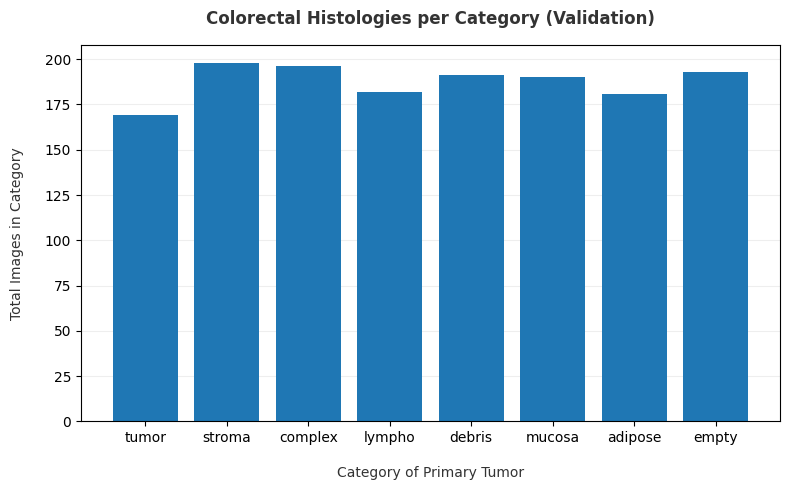

In [11]:
# Bar plot of validation data category counts

plt.rcParams['figure.figsize'] = (8, 5)

fig,ax = plt.subplots()

ax.bar(valid_counts[0],valid_counts[1], tick_label=categories)
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#EEEEEE')
ax.xaxis.grid(False)

ax.set_xlabel('Category of Primary Tumor', labelpad=15, color='#333333')
ax.set_ylabel('Total Images in Category', labelpad=15, color='#333333')
ax.set_title('Colorectal Histologies per Category (Validation)', pad=15, color='#333333',
             weight='bold')

fig.tight_layout()

In [12]:
# Get count for unique label values for testing data
test_counts = np.unique(np.fromiter(testing_set.map(lambda x,y: y), float), return_counts=True)

for value, count in zip(*test_counts):
  print(int(value), count)

0 141
1 114
2 132
3 129
4 134
5 106
6 118
7 126


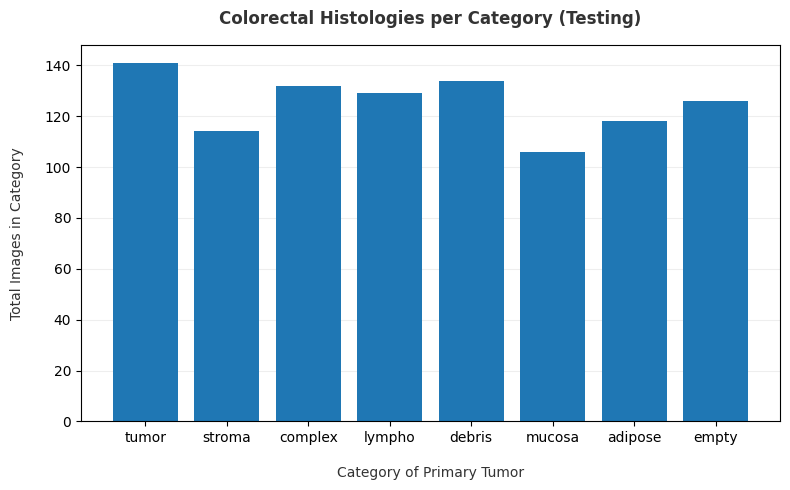

In [13]:
# Bar plot of testing data category counts

plt.rcParams['figure.figsize'] = (8, 5)

fig,ax = plt.subplots()

ax.bar(test_counts[0],test_counts[1], tick_label=categories)
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#EEEEEE')
ax.xaxis.grid(False)

ax.set_xlabel('Category of Primary Tumor', labelpad=15, color='#333333')
ax.set_ylabel('Total Images in Category', labelpad=15, color='#333333')
ax.set_title('Colorectal Histologies per Category (Testing)', pad=15, color='#333333',
             weight='bold')

fig.tight_layout()

In [14]:
# One hot encode labels for each data set

def label_format(image, label):
  return (image, tf.one_hot(label, depth=8))

training_set = training_set.map(label_format)
testing_set = testing_set.map(label_format)
validation_set = validation_set.map(label_format)

In [15]:
# Reshape training dataset to fit the model

def expand_dims_fn(image, label):
    # Apply tf.expand_dims to the image tensor
    image = tf.expand_dims(image, axis=0)
    label = tf.expand_dims(label, axis=0)
    return image, label

# Use tf.map to apply the function to each element in the dataset
train_dataset = training_set.map(expand_dims_fn)
test_dataset = testing_set.map(expand_dims_fn)
valid_dataset = validation_set.map(expand_dims_fn)

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

batch_size = 32

# number of categories
num_classes = len(categories)

# Create the model
model = Sequential([
  #rescaling the images
  layers.Rescaling(1./255, input_shape=(150, 150, 3)),

  # Convolution layer with 16 layers
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  # Takes max value and return, condenses
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  # Flatten will condense down to single layer
  layers.Flatten(),
  # Fully connected layers
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, activation='softmax')
])

In [17]:
# Compile the model

model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

In [18]:
# View all layers of the network
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 150, 150, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 150, 150, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 75, 75, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 37, 37, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 37, 37, 64)        1

In [19]:
# Train with 10 epochs

epochs=10
history = model.fit(
  train_dataset,
  validation_data=valid_dataset,
  epochs=epochs
)

Epoch 1/10
2500/2500 [==============================] - 143s 56ms/step - loss: 1.2634 - accuracy: 0.4428 - val_loss: 1.0381 - val_accuracy: 0.6313
Epoch 2/10
2500/2500 [==============================] - 134s 54ms/step - loss: 0.8665 - accuracy: 0.6284 - val_loss: 0.7680 - val_accuracy: 0.7487
Epoch 3/10
2500/2500 [==============================] - 134s 54ms/step - loss: 0.6683 - accuracy: 0.7292 - val_loss: 0.7773 - val_accuracy: 0.7367
Epoch 4/10
2500/2500 [==============================] - 142s 57ms/step - loss: 0.4611 - accuracy: 0.8252 - val_loss: 0.9650 - val_accuracy: 0.6920
Epoch 5/10
2500/2500 [==============================] - 141s 56ms/step - loss: 0.3416 - accuracy: 0.8800 - val_loss: 1.9828 - val_accuracy: 0.5900
Epoch 6/10
2500/2500 [==============================] - 140s 56ms/step - loss: 0.2772 - accuracy: 0.8940 - val_loss: 1.5272 - val_accuracy: 0.6747
Epoch 7/10
2500/2500 [==============================] - 141s 56ms/step - loss: 0.1904 - accuracy: 0.9396 - val_loss: 1

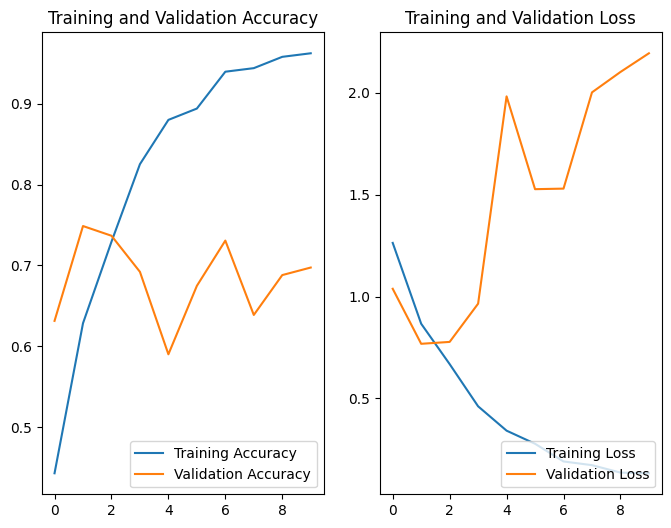

In [20]:
# Plot training and validation accuracy and loss

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend(loc='lower right')
plt.show()

In [21]:
# The above shows possible overfitting as there is a large gap between the training and validation accuracy, and that validation accuracy stalls at around 70%
# To combat overfitting, I will add dropout layers to the model

# Create the model
drop_model = Sequential([
  #rescaling
  layers.Rescaling(1./255, input_shape=(150, 150, 3)),

  # Convolution layer with 16 layers
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  # Takes max value and return, condenses
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2), # adding dropout layer for overfitting
  #Flatten will condense down to single layer
  layers.Flatten(),
  #fully connected layers
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, activation='softmax')
])

drop_model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

# Train with 10 epochs

epochs=10
history = drop_model.fit(
  train_dataset,
  validation_data=valid_dataset,
  epochs=epochs
)

Epoch 1/10
2500/2500 [==============================] - 146s 58ms/step - loss: 1.3386 - accuracy: 0.4112 - val_loss: 0.9829 - val_accuracy: 0.6553
Epoch 2/10
2500/2500 [==============================] - 137s 55ms/step - loss: 0.9622 - accuracy: 0.5520 - val_loss: 0.8026 - val_accuracy: 0.6867
Epoch 3/10
2500/2500 [==============================] - 144s 58ms/step - loss: 0.8024 - accuracy: 0.6520 - val_loss: 0.8086 - val_accuracy: 0.6267
Epoch 4/10
2500/2500 [==============================] - 143s 57ms/step - loss: 0.5946 - accuracy: 0.7656 - val_loss: 0.6533 - val_accuracy: 0.7773
Epoch 5/10
2500/2500 [==============================] - 139s 55ms/step - loss: 0.4402 - accuracy: 0.8304 - val_loss: 0.8568 - val_accuracy: 0.7193
Epoch 6/10
2500/2500 [==============================] - 143s 57ms/step - loss: 0.3221 - accuracy: 0.8892 - val_loss: 1.1849 - val_accuracy: 0.7053
Epoch 7/10
2500/2500 [==============================] - 137s 55ms/step - loss: 0.2520 - accuracy: 0.9040 - val_loss: 1

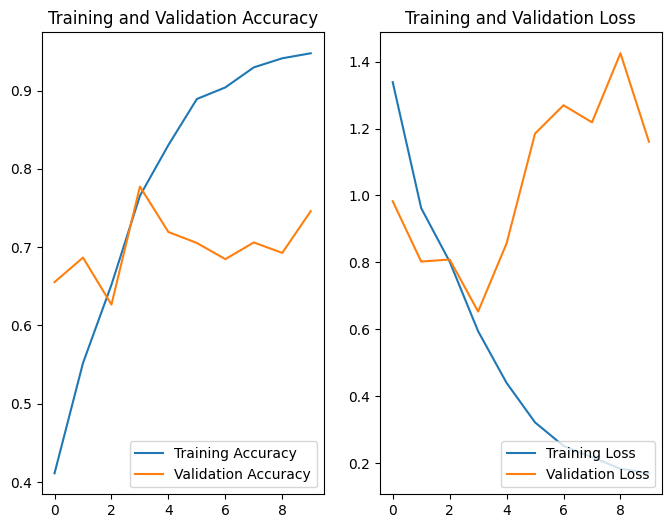

In [22]:
# Plot training and validation accuracy and loss after drop layer is added

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='lower right')
plt.title('Training and Validation Loss')
plt.show()

In [27]:
# Hyper parameter tune with Keras tuner

def model_builder(hp):
  '''A model function that will be input into the Keras tuner to obtain the optimal parameters for the model'''

  model = keras.Sequential()
  model.add(keras.layers.Rescaling(1./255, input_shape=(150, 150, 3)))
  model.add(keras.layers.Conv2D(16, 3, padding='same', activation='relu'))
  model.add(keras.layers.MaxPooling2D())
  model.add(keras.layers.Conv2D(32, 3, padding='same', activation='relu'))
  model.add(keras.layers.MaxPooling2D())
  model.add(keras.layers.Conv2D(64, 3, padding='same', activation='relu'))
  model.add(keras.layers.MaxPooling2D())
  hp_dropout = hp.Float('dropout', min_value=0.2, max_value=0.4, step=0.1)
  model.add(keras.layers.Dropout(hp_dropout))
  model.add(keras.layers.Flatten())
  hp_units = hp.Int('units', min_value=32, max_value=160, step=32) # tune the number of units in dense layer
  model.add(keras.layers.Dense(units=hp_units, activation='relu'))
  model.add(keras.layers.Dense(num_classes, activation='softmax'))
  # Tune the learning rate for the optimizer - 0.01 and 0.001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3]) # Tune the learning rate for the optimizer

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

  return model


In [28]:
# Instantiate keras tuner for hypertuning
#import keras_tuner as kt

tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=5,
                     factor=3)

# Early stopping to stop training once a certain value for validation loss is reached to help prevent overfitting
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# Run hyperparameter search
tuner.search(train_dataset, epochs=50, validation_data=(valid_dataset), callbacks=[stop_early])


# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The optimal number of units in the first densely-connected
layer is {best_hps.get('units')}, the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}, and the optimal dropout rate is {best_hps.get('dropout')}.
""")

Trial 8 Complete [00h 13m 45s]
val_accuracy: 0.12666666507720947

Best val_accuracy So Far: 0.7580000162124634
Total elapsed time: 00h 57m 33s

The optimal number of units in the first densely-connected
layer is 160, the optimal learning rate for the optimizer
is 0.001, and the optimal dropout rate is 0.30000000000000004.



In [29]:
# Select best parameters based on Keras Tuner
final_model = tuner.hypermodel.build(best_hps)

# Apply to training data
final_history = final_model.fit(train_dataset,
  validation_data=valid_dataset,
  epochs=epochs)

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/10
2500/2500 [==============================] - 224s 89ms/step - loss: 1.2746 - accuracy: 0.4412 - val_loss: 1.0512 - val_accuracy: 0.4760
Epoch 2/10
2500/2500 [==============================] - 161s 64ms/step - loss: 0.9045 - accuracy: 0.6108 - val_loss: 0.8865 - val_accuracy: 0.6927
Epoch 3/10
2500/2500 [==============================] - 157s 63ms/step - loss: 0.7341 - accuracy: 0.6872 - val_loss: 0.7779 - val_accuracy: 0.7347
Epoch 4/10
2500/2500 [==============================] - 158s 63ms/step - loss: 0.5692 - accuracy: 0.7700 - val_loss: 0.8411 - val_accuracy: 0.6893
Epoch 5/10
2500/2500 [==============================] - 158s 63ms/step - loss: 0.4326 - accuracy: 0.8276 - val_loss: 0.9214 - val_accuracy: 0.7327
Epoch 6/10
2500/2500 [==============================] - 158s 63ms/step - loss: 0.3107 - accuracy: 0.8860 - val_loss: 1.0177 - val_accuracy: 0.7307
Epoch 7/10
2500/2500 [==============================] - 157s 63ms/step - loss: 0.2477 - accuracy: 0.9128 - val_loss: 1

In [30]:
# Reinstate the model and traing it with the optimal number of epochs
hypermodel = tuner.hypermodel.build(best_hps)

# Retrain the model
hypermodel.fit(train_dataset,validation_data=valid_dataset, epochs=best_epoch)

Epoch 1/4
2500/2500 [==============================] - 169s 66ms/step - loss: 1.2604 - accuracy: 0.4356 - val_loss: 0.9882 - val_accuracy: 0.6340
Epoch 2/4
2500/2500 [==============================] - 157s 63ms/step - loss: 0.9128 - accuracy: 0.5880 - val_loss: 0.8509 - val_accuracy: 0.6973
Epoch 3/4
2500/2500 [==============================] - 158s 63ms/step - loss: 0.7708 - accuracy: 0.6752 - val_loss: 0.8756 - val_accuracy: 0.6820
Epoch 4/4
2500/2500 [==============================] - 157s 63ms/step - loss: 0.6413 - accuracy: 0.7452 - val_loss: 0.8428 - val_accuracy: 0.7147


In [32]:
# Print summary of results from the hyper parameter tuning

tuner.results_summary()

Results summary
Results in ./untitled_project
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 0005 summary
Hyperparameters:
dropout: 0.30000000000000004
units: 160
learning_rate: 0.001
tuner/epochs: 5
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.7580000162124634

Trial 0004 summary
Hyperparameters:
dropout: 0.2
units: 128
learning_rate: 0.001
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 1
tuner/round: 0
Score: 0.699999988079071

Trial 0003 summary
Hyperparameters:
dropout: 0.30000000000000004
units: 128
learning_rate: 0.001
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 1
tuner/round: 0
Score: 0.6380000114440918

Trial 0002 summary
Hyperparameters:
dropout: 0.4
units: 128
learning_rate: 0.01
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 1
tuner/round: 0
Score: 0.12666666507720947

Trial 0006 summary
Hyperparameters:
dropout: 0.2
units: 128
learning_rate: 0.01
tuner/epochs: 5
tuner/initial_epoch: 0
tuner/bracket: 0

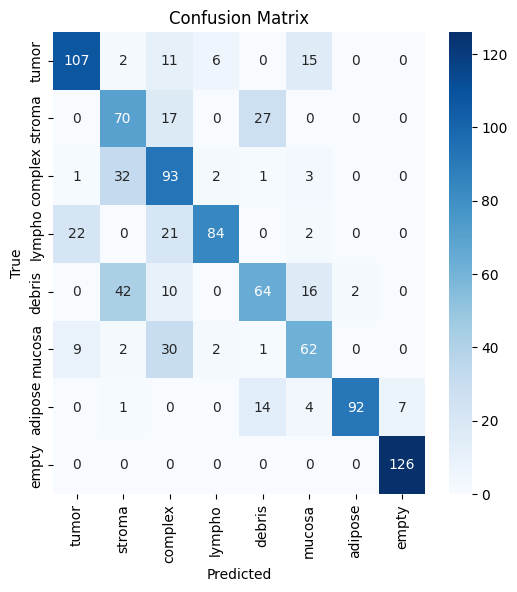

1000/1000 [==============================] - 14s 14ms/step - loss: 0.8351 - accuracy: 0.6980
[test loss, test accuracy]: [0.8350884318351746, 0.6980000138282776]


In [45]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
# Evaluate final model on the testing data
#val_pred = hypermodel.predict(test_dataset)
#val_pred_class = np.argmax(val_pred, axis=1)

val_true_classes = np.argmax(np.concatenate([y.numpy() for _, y in test_dataset]), axis=1)


cm = confusion_matrix(val_true_classes, val_pred_class)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

eval_results = hypermodel.evaluate(test_dataset)
print("[test loss, test accuracy]:", eval_results)